Implementing a Basic RNN Model

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [3]:
# Load the dataset
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'
dataframe = pd.read_csv(url, usecols=[1], engine='python')
# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataframe.values)
# Split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size], dataset[train_size:len(dataset)]

In [5]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# Reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [6]:
# Create and fit the RNN model
model = Sequential()
model.add(SimpleRNN(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 - 1s - 14ms/step - loss: 0.1435
Epoch 2/100
94/94 - 0s - 1ms/step - loss: 0.0593
Epoch 3/100
94/94 - 0s - 1ms/step - loss: 0.0417
Epoch 4/100
94/94 - 0s - 1ms/step - loss: 0.0356
Epoch 5/100
94/94 - 0s - 3ms/step - loss: 0.0309
Epoch 6/100
94/94 - 0s - 3ms/step - loss: 0.0264
Epoch 7/100
94/94 - 0s - 2ms/step - loss: 0.0225
Epoch 8/100
94/94 - 0s - 3ms/step - loss: 0.0191
Epoch 9/100
94/94 - 0s - 2ms/step - loss: 0.0157
Epoch 10/100
94/94 - 0s - 3ms/step - loss: 0.0132
Epoch 11/100
94/94 - 0s - 1ms/step - loss: 0.0106
Epoch 12/100
94/94 - 0s - 1ms/step - loss: 0.0088
Epoch 13/100
94/94 - 0s - 1ms/step - loss: 0.0072
Epoch 14/100
94/94 - 0s - 2ms/step - loss: 0.0057
Epoch 15/100
94/94 - 0s - 2ms/step - loss: 0.0046
Epoch 16/100
94/94 - 0s - 4ms/step - loss: 0.0039
Epoch 17/100
94/94 - 0s - 3ms/step - loss: 0.0033
Epoch 18/100
94/94 - 0s - 2ms/step - loss: 0.0028
Epoch 19/100
94/94 - 0s - 3ms/step - loss: 0.0026
Epoch 20/100
94/94 - 0s - 3ms/step - loss: 0.0023
Epoch 21/100
94/94 -

In [7]:
# Make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# Invert predictions to original scale
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# Calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Train Score: 22.59 RMSE
Test Score: 55.90 RMSE


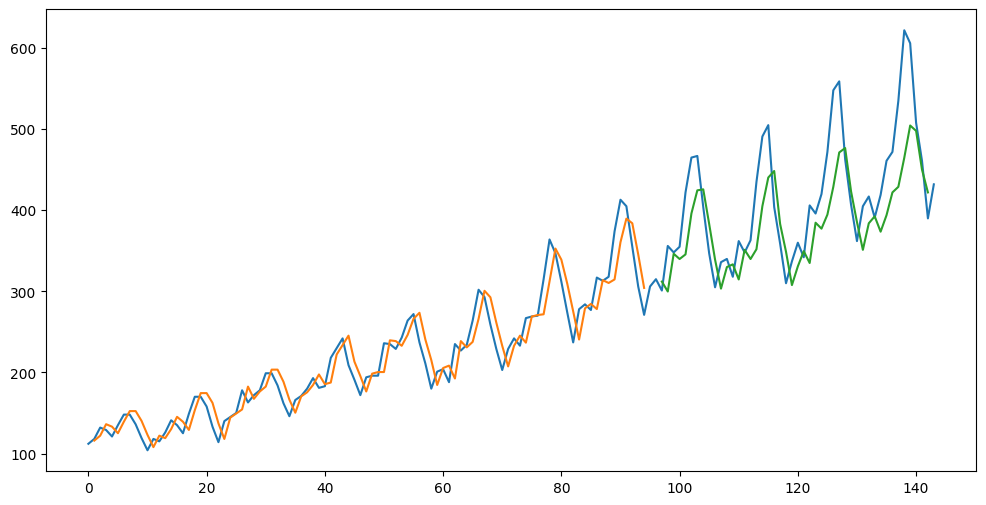

In [8]:
# Shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# Shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# Plot baseline and predictions
plt.figure(figsize=(12,6))
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

This basic RNN model uses a single layer of RNN followed by a dense layer to predict the future values based on the previous observations defined by look_back. The model is trained with the Adam optimizer, which is an extension to stochastic gradient descent that has recently seen broader adoption for deep learning applications in computer vision and natural language processing.
The plotted results will show how well the RNN model predicts the number of passengers. The key is to experiment with different configurations like increasing look_back, changing the number of neurons in the RNN layer, or adding more layers to improve the accuracy of predictions.

Stacking RNN Layers and Bi-directional RNNs

In [20]:
# Load the dataset
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'
dataframe = pd.read_csv(url, usecols=[1], engine='python')
# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataframe.values)
# Split and prepare the data
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size], dataset[train_size:len(dataset)]
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# Reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [19]:
def train_and_evaluate_model(model, trainX, trainY, testX, testY):
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
    # Make predictions
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)
    # Invert predictions
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform([trainY])
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform([testY])
    # Calculate and print RMSE
    trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
    testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
    print('Train Score: %.2f RMSE' % (trainScore))
    print('Test Score: %.2f RMSE' % (testScore))
    return trainPredict, testPredict

In [16]:
# Create the Stacked RNN model
stacked_rnn_model = Sequential([
    SimpleRNN(4, input_shape=(1, look_back), return_sequences=True),
    SimpleRNN(4, return_sequences=False),
    Dense(1)
])
# Train and evaluate the stacked RNN
trainPredict, testPredict = train_and_evaluate_model(stacked_rnn_model, trainX, trainY, testX, testY)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 - 2s - 25ms/step - loss: 0.0234
Epoch 2/100
94/94 - 0s - 3ms/step - loss: 0.0094
Epoch 3/100
94/94 - 0s - 3ms/step - loss: 0.0070
Epoch 4/100
94/94 - 0s - 3ms/step - loss: 0.0048
Epoch 5/100
94/94 - 0s - 2ms/step - loss: 0.0034
Epoch 6/100
94/94 - 0s - 3ms/step - loss: 0.0027
Epoch 7/100
94/94 - 0s - 2ms/step - loss: 0.0023
Epoch 8/100
94/94 - 0s - 2ms/step - loss: 0.0022
Epoch 9/100
94/94 - 0s - 2ms/step - loss: 0.0021
Epoch 10/100
94/94 - 0s - 3ms/step - loss: 0.0020
Epoch 11/100
94/94 - 0s - 3ms/step - loss: 0.0020
Epoch 12/100
94/94 - 0s - 2ms/step - loss: 0.0020
Epoch 13/100
94/94 - 0s - 4ms/step - loss: 0.0023
Epoch 14/100
94/94 - 0s - 3ms/step - loss: 0.0021
Epoch 15/100
94/94 - 0s - 3ms/step - loss: 0.0021
Epoch 16/100
94/94 - 1s - 6ms/step - loss: 0.0021
Epoch 17/100
94/94 - 1s - 7ms/step - loss: 0.0021
Epoch 18/100
94/94 - 0s - 5ms/step - loss: 0.0020
Epoch 19/100
94/94 - 0s - 3ms/step - loss: 0.0023
Epoch 20/100
94/94 - 0s - 2ms/step - loss: 0.0019
Epoch 21/100
94/94 -

In [22]:
from tensorflow.keras.layers import SimpleRNN, Dense, Bidirectional
# Create the Bi-directional RNN model
bi_rnn_model = Sequential([
    Bidirectional(SimpleRNN(4, input_shape=(1, look_back))),
    Dense(1)
])
# Train and evaluate the bi-directional RNN
trainPredict, testPredict = train_and_evaluate_model(bi_rnn_model, trainX, trainY, testX, testY)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 - 4s - 41ms/step - loss: 0.0713
Epoch 2/100
94/94 - 0s - 3ms/step - loss: 0.0252
Epoch 3/100
94/94 - 0s - 3ms/step - loss: 0.0187
Epoch 4/100
94/94 - 0s - 3ms/step - loss: 0.0145
Epoch 5/100
94/94 - 0s - 4ms/step - loss: 0.0108
Epoch 6/100
94/94 - 0s - 4ms/step - loss: 0.0081
Epoch 7/100
94/94 - 1s - 7ms/step - loss: 0.0061
Epoch 8/100
94/94 - 1s - 6ms/step - loss: 0.0045
Epoch 9/100
94/94 - 0s - 2ms/step - loss: 0.0035
Epoch 10/100
94/94 - 0s - 3ms/step - loss: 0.0029
Epoch 11/100
94/94 - 0s - 3ms/step - loss: 0.0025
Epoch 12/100
94/94 - 0s - 3ms/step - loss: 0.0023
Epoch 13/100
94/94 - 0s - 2ms/step - loss: 0.0020
Epoch 14/100
94/94 - 0s - 3ms/step - loss: 0.0021
Epoch 15/100
94/94 - 0s - 3ms/step - loss: 0.0020
Epoch 16/100
94/94 - 0s - 3ms/step - loss: 0.0020
Epoch 17/100
94/94 - 0s - 2ms/step - loss: 0.0020
Epoch 18/100
94/94 - 0s - 3ms/step - loss: 0.0020
Epoch 19/100
94/94 - 0s - 3ms/step - loss: 0.0020
Epoch 20/100
94/94 - 0s - 3ms/step - loss: 0.0020
Epoch 21/100
94/94 -

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Train Score: 22.65 RMSE
Test Score: 58.93 RMSE


After running the above code, you would compare the RMSE (Root Mean Squared Error) of the basic RNN, stacked RNN, and bi-directional RNN models. Generally, you may find that:
    Stacked RNN might show improved performance over the basic RNN because it can capture more complex patterns and relationships in the data.
    Bi-directional RNN typically provides better results on tasks where understanding the context from both past and future can enhance prediction accuracy, which is particularly beneficial in sequence modeling tasks like this.


Exploring Hybrid Architectures

In [34]:
# Load the dataset
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'
dataframe = pd.read_csv(url, usecols=[1], engine='python')
# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataframe.values)
# Split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size], dataset[train_size:len(dataset)]
# Function to create dataset
def create_dataset(dataset, look_back=3):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# Reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [36]:
# Create the hybrid CNN-RNN model
model = Sequential([
    Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(look_back, 1)),
    MaxPooling1D(pool_size=2),
    SimpleRNN(50),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')
# Train the model
model.fit(trainX, trainY, epochs=100, verbose=2)


Epoch 1/100
3/3 - 2s - 542ms/step - loss: 0.0634
Epoch 2/100
3/3 - 0s - 9ms/step - loss: 0.0350
Epoch 3/100
3/3 - 0s - 10ms/step - loss: 0.0176
Epoch 4/100
3/3 - 0s - 9ms/step - loss: 0.0094
Epoch 5/100
3/3 - 0s - 9ms/step - loss: 0.0091
Epoch 6/100
3/3 - 0s - 10ms/step - loss: 0.0110
Epoch 7/100
3/3 - 0s - 9ms/step - loss: 0.0114
Epoch 8/100
3/3 - 0s - 9ms/step - loss: 0.0099
Epoch 9/100
3/3 - 0s - 9ms/step - loss: 0.0077
Epoch 10/100
3/3 - 0s - 20ms/step - loss: 0.0067
Epoch 11/100
3/3 - 0s - 10ms/step - loss: 0.0061
Epoch 12/100
3/3 - 0s - 9ms/step - loss: 0.0063
Epoch 13/100
3/3 - 0s - 9ms/step - loss: 0.0063
Epoch 14/100
3/3 - 0s - 9ms/step - loss: 0.0060
Epoch 15/100
3/3 - 0s - 10ms/step - loss: 0.0056
Epoch 16/100
3/3 - 0s - 20ms/step - loss: 0.0052
Epoch 17/100
3/3 - 0s - 9ms/step - loss: 0.0050
Epoch 18/100
3/3 - 0s - 9ms/step - loss: 0.0050
Epoch 19/100
3/3 - 0s - 9ms/step - loss: 0.0049
Epoch 20/100
3/3 - 0s - 9ms/step - loss: 0.0048
Epoch 21/100
3/3 - 0s - 12ms/step - loss:

In [37]:
# Predict
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# Invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# Calculate and print RMSE
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
print('Test Score: %.2f RMSE' % (testScore))

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Train Score: 26.29 RMSE
Test Score: 58.74 RMSE


Compare the RMSE of this hybrid model with those of the basic RNN, stacked RNN, and bi-directional RNN. You might find that the hybrid model outperforms the others due to the effective feature extraction by CNN layers.Using a hybrid model like CNN+RNN can leverage the strengths of both architectures, providing a robust approach to sequence modeling tasks. This approach might be particularly beneficial when the sequence data also has spatial patterns, which is typical in fields like finance (e.g., stock prices), climate (e.g., temperature over time), and healthcare (e.g., ECG signals).